# EAGLEBINE_DATA MERGING

## 1.1 Import some great packages


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
%matplotlib inline
#progress bar
from tqdm.notebook import tqdm
# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

# 2 Organize Eaglebine temperature data

## 2.1 read in BHT

In [2]:
Eaglebine_BHT = pd.read_excel('Eaglebine BHT TSC data for SPE April 21 2020.xlsx')
Eaglebine_BHT['TempC_BHT'] = (Eaglebine_BHT['BHTorMRT (maximum recorded temperature) oF'] - 32) * (5./9.)
Eaglebine_BHT.head()

,UWI,SurfLat,SurfLong,TD (ft),GL(ft),BHT_below sea level (ft),BHT_ subsurface (ft),BHTorMRT (maximum recorded temperature) oF,TSC or ORT (time since circulation or original recorded time in hours),TempC_BHT
0,42013301410000,28.690426,-98.470138,19629.0,345.90,12222.50,12568.4,143.0,5.50,61.666667
1,42013301930000,28.779921,-98.208313,10775.0,397.40,10396.00,10793.4,225.0,11.00,107.222222
2,42013302760000,28.994360,-98.421799,6168.0,460.40,5733.00,6193.4,150.0,5.50,65.555556
3,42013305480000,28.759118,-98.156410,8198.0,410.40,7806.00,8216.4,170.0,5.00,76.666667
4,42013310190000,28.817400,-98.155319,11000.0,508.92,10509.48,11018.4,210.0,7.75,98.888889


In [3]:
print("number of unique wells: " + str(len(pd.unique(Eaglebine_BHT['UWI']))))

number of unique wells: 324


## 2.2 Read in Eaglebine synthetic "true formation temperature"

In [4]:
Eaglebine_Truth = pd.read_excel('Eaglebine TrueTemp_Train2.xlsx')
Eaglebine_Truth.head()

,UWI,Depth sub-sea (feet),True Temperature (oF)
0,42013301410000,-350,70.33
1,42013301410000,-300,70.33
2,42013301410000,-250,70.33
3,42013301410000,-200,71.49
4,42013301410000,-150,72.66


In [5]:
# convert to Celsius
Eaglebine_Truth['TempTrue_degC'] = (Eaglebine_Truth['True Temperature   (oF)'] - 32) * (5./9.)
Eaglebine_Truth['TrueTemp_datasource_syn'] = 'synthetic'

In [6]:
print("number of unique wells in Eaglebine in training set: " + str(len(pd.unique(Eaglebine_Truth['UWI']))))

number of unique wells in Eaglebine in training set: 243


## 2.3 Combine measured BHT and true temperature

In [6]:
Eaglebine_Combined = Eaglebine_BHT.merge(Eaglebine_Truth, on='UWI', how='left')

In [7]:
# only keep from the synthetic data, the temperature at the elevation closest to the model
Eaglebine_Combined['diff_depth'] = Eaglebine_Combined['Depth sub-sea (feet)']-Eaglebine_Combined['BHT_below sea level (ft)']
Eaglebine_Combined['diff_depth_abs'] = np.abs(Eaglebine_Combined['diff_depth'])
idx = Eaglebine_Combined.groupby(['UWI'])['diff_depth_abs'].transform(min) == Eaglebine_Combined['diff_depth_abs']
TrueTempUWI = Eaglebine_Combined.loc[idx, ['UWI', 'diff_depth_abs', 'TempTrue_degC','TrueTemp_datasource_syn']]
TrueTempUWI = TrueTempUWI.copy(deep=True)
Eaglebine_Combined_cln = Eaglebine_BHT.merge(TrueTempUWI, on='UWI', how='left')
Eaglebine_Combined_cln.head()

,UWI,SurfLat,SurfLong,TD (ft),GL(ft),BHT_below sea level (ft),BHT_ subsurface (ft),BHTorMRT (maximum recorded temperature) oF,TSC or ORT (time since circulation or original recorded time in hours),TempC_BHT,diff_depth_abs,TempTrue_degC,TrueTemp_datasource_syn
0,42013301410000,28.690426,-98.470138,19629.0,345.90,12222.50,12568.4,143.0,5.50,61.666667,22.50,141.555556,synthetic
1,42013301930000,28.779921,-98.208313,10775.0,397.40,10396.00,10793.4,225.0,11.00,107.222222,4.00,132.038889,synthetic
2,42013302760000,28.994360,-98.421799,6168.0,460.40,5733.00,6193.4,150.0,5.50,65.555556,17.00,89.161111,synthetic
3,42013305480000,28.759118,-98.156410,8198.0,410.40,7806.00,8216.4,170.0,5.00,76.666667,6.00,107.961111,synthetic
4,42013310190000,28.817400,-98.155319,11000.0,508.92,10509.48,11018.4,210.0,7.75,98.888889,9.48,133.722222,synthetic


In [8]:
len(Eaglebine_Combined_cln)

324

In [9]:
Eaglebine_Combined_cln.columns

Index(['UWI', 'SurfLat', 'SurfLong', 'TD (ft)', 'GL(ft)',
       'BHT_below sea level (ft)', 'BHT_ subsurface (ft)',
       'BHTorMRT (maximum recorded temperature) oF',
       'TSC or ORT (time since circulation or original recorded time in hours)',
       'TempC_BHT', 'diff_depth_abs', 'TempTrue_degC',
       'TrueTemp_datasource_syn'],
      dtype='object')

## 2.4 Read in static temperature information and merge into dataset

In [10]:
Static_log_temp = pd.read_csv('Data_static_logs.csv')
Static_log_temp.head()

,Well_ID,Depth (ft),Temp (degC),Field
0,42013301930000,10700.0,132.778000,Eaglebine
1,42041305800000,7360.0,82.777778,Eaglebine
2,42041311700000,7828.0,118.888889,Eaglebine
3,42041311980000,7954.0,105.000000,Eaglebine
4,42051305380000,8380.0,111.111111,Eaglebine


In [11]:
Static_log_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Well_ID      41 non-null     object 
 1   Depth (ft)   40 non-null     float64
 2   Temp (degC)  41 non-null     float64
 3   Field        41 non-null     object 
dtypes: float64(2), object(2)
memory usage: 1.4+ KB


In [12]:
Eaglebine_Combined_cln['UWI'] = Eaglebine_Combined_cln['UWI'].astype(str)
Eaglebine_Combined_cln = Eaglebine_Combined_cln.copy(deep=True)
#Eaglebine_Combined_cln['TrueTemp_datasource_syn'] = 'synthetic'
Static_log_temp['TrueTemp_datasource_stat'] = 'static_temp_logs'
Eaglebine_Combined_stat = Eaglebine_Combined_cln.merge(Static_log_temp, left_on='UWI',right_on='Well_ID', how='left')

In [13]:
# Coalesce columns together with priority for true temperature measurements
Eaglebine_Combined_stat['TempC_Fin'] = Eaglebine_Combined_stat['Temp (degC)'].fillna(Eaglebine_Combined_stat['TempTrue_degC'])
Eaglebine_Combined_stat['TrueTemp_datasource'] = Eaglebine_Combined_stat['TrueTemp_datasource_stat'].fillna(Eaglebine_Combined_stat['TrueTemp_datasource_syn'])
Eaglebine_Combined_stat.head()

,UWI,SurfLat,SurfLong,TD (ft),GL(ft),BHT_below sea level (ft),BHT_ subsurface (ft),BHTorMRT (maximum recorded temperature) oF,TSC or ORT (time since circulation or original recorded time in hours),TempC_BHT,diff_depth_abs,TempTrue_degC,TrueTemp_datasource_syn,Well_ID,Depth (ft),Temp (degC),Field,TrueTemp_datasource_stat,TempC_Fin,TrueTemp_datasource
0,42013301410000,28.690426,-98.470138,19629.0,345.90,12222.50,12568.4,143.0,5.50,61.666667,22.50,141.555556,synthetic,NaN,NaN,NaN,NaN,NaN,141.555556,synthetic
1,42013301930000,28.779921,-98.208313,10775.0,397.40,10396.00,10793.4,225.0,11.00,107.222222,4.00,132.038889,synthetic,42013301930000,10700.0,132.778,Eaglebine,static_temp_logs,132.778000,static_temp_logs
2,42013302760000,28.994360,-98.421799,6168.0,460.40,5733.00,6193.4,150.0,5.50,65.555556,17.00,89.161111,synthetic,NaN,NaN,NaN,NaN,NaN,89.161111,synthetic
3,42013305480000,28.759118,-98.156410,8198.0,410.40,7806.00,8216.4,170.0,5.00,76.666667,6.00,107.961111,synthetic,NaN,NaN,NaN,NaN,NaN,107.961111,synthetic
4,42013310190000,28.817400,-98.155319,11000.0,508.92,10509.48,11018.4,210.0,7.75,98.888889,9.48,133.722222,synthetic,NaN,NaN,NaN,NaN,NaN,133.722222,synthetic


In [15]:
Eaglebine_Combined_stat.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 324 entries, 0 to 323
Data columns (total 20 columns):
 #   Column                                                                  Non-Null Count  Dtype  
---  ------                                                                  --------------  -----  
 0   UWI                                                                     324 non-null    object 
 1   SurfLat                                                                 324 non-null    float64
 2   SurfLong                                                                324 non-null    float64
 3   TD (ft)                                                                 324 non-null    float64
 4   GL(ft)                                                                  324 non-null    float64
 5   BHT_below sea level (ft)                                                324 non-null    float64
 6   BHT_ subsurface (ft)                                                    324 non-nu

In [14]:
Eaglebine_Combined_stat.nunique()

UWI                                                                       324
SurfLat                                                                   324
SurfLong                                                                  324
TD (ft)                                                                   298
GL(ft)                                                                    260
BHT_below sea level (ft)                                                  322
BHT_ subsurface (ft)                                                      306
BHTorMRT (maximum recorded temperature) oF                                134
TSC or ORT (time since circulation or original recorded time in hours)     62
TempC_BHT                                                                 134
diff_depth_abs                                                            116
TempTrue_degC                                                             239
TrueTemp_datasource_syn                                         

## 2.5 plot the eaglebine temperature data

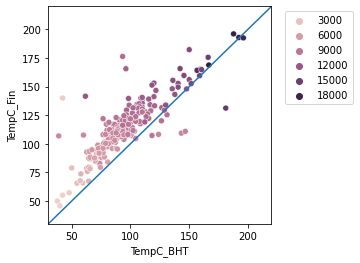

In [15]:
import matplotlib.pyplot as plt
plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=(4,4))

sns.scatterplot(data=Eaglebine_Combined_stat, x="TempC_BHT", y="TempC_Fin", hue='BHT_below sea level (ft)', ax=ax)

ax.set_xlim([30, 220])
ax.set_ylim([30, 220])
ax.plot([0, 220], [0, 220])
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

In [16]:
Eaglebine_Combined_stat.columns

Index(['UWI', 'SurfLat', 'SurfLong', 'TD (ft)', 'GL(ft)',
       'BHT_below sea level (ft)', 'BHT_ subsurface (ft)',
       'BHTorMRT (maximum recorded temperature) oF',
       'TSC or ORT (time since circulation or original recorded time in hours)',
       'TempC_BHT', 'diff_depth_abs', 'TempTrue_degC',
       'TrueTemp_datasource_syn', 'Well_ID', 'Depth (ft)', 'Temp (degC)',
       'Field', 'TrueTemp_datasource_stat', 'TempC_Fin',
       'TrueTemp_datasource'],
      dtype='object')

In [17]:
## Dropping some columns which are repititive
Eaglebine_Combined_stat.drop(columns =['TempTrue_degC',
       'TrueTemp_datasource_syn', 'Well_ID','Field','Depth (ft)','Temp (degC)','Field','TrueTemp_datasource_stat','BHTorMRT (maximum recorded temperature) oF'],inplace=True)

In [18]:
Eaglebine_Combined_stat.head()

,UWI,SurfLat,SurfLong,TD (ft),GL(ft),BHT_below sea level (ft),BHT_ subsurface (ft),TSC or ORT (time since circulation or original recorded time in hours),TempC_BHT,diff_depth_abs,TempC_Fin,TrueTemp_datasource
0,42013301410000,28.690426,-98.470138,19629.0,345.90,12222.50,12568.4,5.50,61.666667,22.50,141.555556,synthetic
1,42013301930000,28.779921,-98.208313,10775.0,397.40,10396.00,10793.4,11.00,107.222222,4.00,132.778000,static_temp_logs
2,42013302760000,28.994360,-98.421799,6168.0,460.40,5733.00,6193.4,5.50,65.555556,17.00,89.161111,synthetic
3,42013305480000,28.759118,-98.156410,8198.0,410.40,7806.00,8216.4,5.00,76.666667,6.00,107.961111,synthetic
4,42013310190000,28.817400,-98.155319,11000.0,508.92,10509.48,11018.4,7.75,98.888889,9.48,133.722222,synthetic


In [19]:
# Renaming column names
Eaglebine_Combined_stat=Eaglebine_Combined_stat.rename(columns={'TempC_Fin': 'True_TempC_Final','TSC or ORT (time since circulation or original recorded time in hours)':'TSC(hrs)'})

In [20]:
Eaglebine_Combined_stat.describe()

,SurfLat,SurfLong,TD (ft),GL(ft),BHT_below sea level (ft),BHT_ subsurface (ft),TSC(hrs),TempC_BHT,diff_depth_abs,True_TempC_Final
count,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.00000,324.000000,243.000000,243.000000
mean,29.797972,-97.122295,9744.379630,440.697654,8524.312222,8965.009877,6.76929,94.928669,89.028642,114.340356
std,1.929210,5.557704,2992.341139,131.695386,2730.324947,2693.450734,8.36953,26.331159,514.462798,24.034569
min,0.000000,-100.506157,4016.000000,195.150000,1843.000000,2221.400000,0.00000,37.777778,0.900000,45.838889
25%,28.920858,-98.156673,7957.000000,354.250000,7262.375000,7705.150000,3.50000,79.861111,7.090000,101.680556
50%,30.187270,-96.866112,8705.500000,410.400000,8148.450000,8525.900000,5.50000,90.555556,13.000000,111.811111
75%,30.658118,-96.457820,10962.250000,493.650000,9633.850000,10070.400000,8.00000,104.444444,19.000000,125.313889
max,31.422720,0.000000,24037.000000,923.400000,19132.000000,19518.400000,124.50000,196.111111,4279.000000,196.027778


## 2.6 Read and transform Mud datails and merge in to Data

In [21]:
mud_details = pd.read_excel('Eaglebine mud weight SPE April 21 2021.xlsx')

In [22]:
mud_details['mud depth']=mud_details['MW@Depth(KB)']-mud_details['KB']

              UWI     TD     KB  Mud Wt  MW@Depth(KB)  mud depth
0  42013301410000  19629  327.5     9.3          4404     4076.5
1  42013301410000  19629  327.5    11.9         12550    12222.5
2  42013301410000  19629  327.5    11.2         12650    12322.5
(515, 6)


<AxesSubplot:>

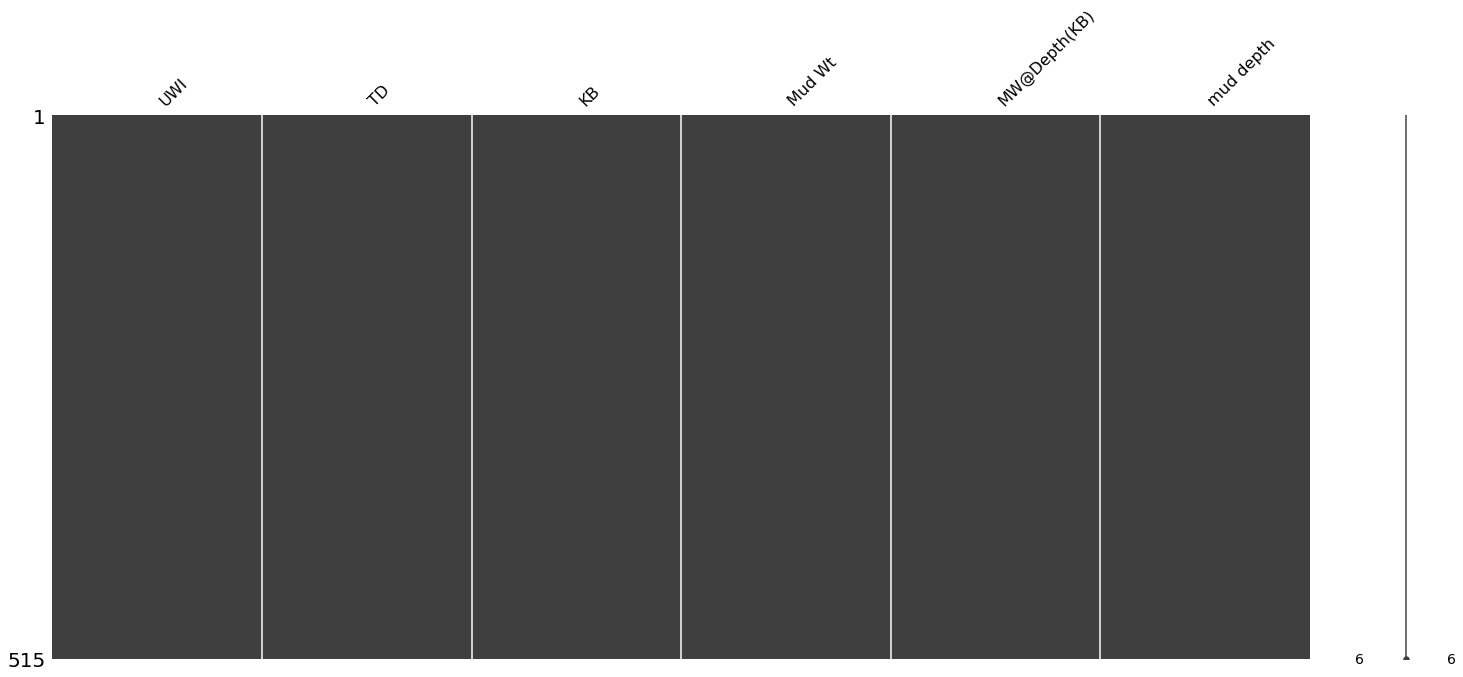

In [23]:
print(mud_details.head(3))
print(mud_details.shape)
msno.matrix(mud_details)

In [24]:
## Using mud weight data nearest to BHT depth
mud_details['UWI'] = mud_details['UWI'].astype(str)
mud_Combined = Eaglebine_Combined_stat.merge(mud_details, on='UWI', how='left')
mud_Combined['mud_diff_depth'] = mud_Combined['mud depth']-mud_Combined['BHT_below sea level (ft)']
mud_Combined['mud_diff_depth_abs'] = np.abs(mud_Combined['mud_diff_depth'])
mud_Combined.sort_values(['UWI','mud_diff_depth_abs'],ascending=[False,True],inplace=True)
mud_Combined.drop_duplicates('UWI',inplace=True)
print(mud_Combined.shape)
mud_Combined

(324, 19)


,UWI,SurfLat,SurfLong,TD (ft),GL(ft),BHT_below sea level (ft),BHT_ subsurface (ft),TSC(hrs),TempC_BHT,diff_depth_abs,True_TempC_Final,TrueTemp_datasource,TD,KB,Mud Wt,MW@Depth(KB),mud depth,mud_diff_depth,mud_diff_depth_abs
522,42507326870000,29.001905,-99.586898,4016.0,787.90,3246.50,4034.4,4.00,50.000000,3.50,78.888889,static_temp_logs,4016.0,769.50,10.30,4016.0,3246.50,0.000000e+00,0.000000e+00
521,42507312960000,29.075911,-100.006371,7191.0,839.85,6329.55,7169.4,9.00,67.222222,20.45,94.794444,synthetic,7191.0,821.45,9.30,7151.0,6329.55,0.000000e+00,0.000000e+00
518,42507312420000,28.742901,-100.077454,10120.0,660.70,3257.70,3918.4,3.00,54.444444,NaN,NaN,NaN,10120.0,642.30,9.70,3900.0,3257.70,0.000000e+00,0.000000e+00
512,42507007550000,28.775181,-99.562393,16152.0,766.40,4254.00,5020.4,4.00,65.555556,4.00,78.161111,synthetic,16152.0,748.00,9.70,5002.0,4254.00,0.000000e+00,0.000000e+00
511,42493322270000,29.059620,-98.210121,6390.0,487.40,5921.00,6408.4,6.00,73.333333,NaN,NaN,NaN,6390.0,469.00,9.85,6390.0,5921.00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14,42013310190000,28.817400,-98.155319,11000.0,508.92,10509.48,11018.4,7.75,98.888889,9.48,133.722222,synthetic,11000.0,490.52,10.80,11000.0,10509.48,0.000000e+00,0.000000e+00
13,42013305480000,28.759118,-98.156410,8198.0,410.40,7806.00,8216.4,5.00,76.666667,6.00,107.961111,synthetic,8198.0,392.00,10.10,8198.0,7806.00,-9.094947e-13,9.094947e-13
12,42013302760000,28.994360,-98.421799,6168.0,460.40,5733.00,6193.4,5.50,65.555556,17.00,89.161111,synthetic,6168.0,442.00,10.10,6175.0,5733.00,0.000000e+00,0.000000e+00
11,42013301930000,28.779921,-98.208313,10775.0,397.40,10396.00,10793.4,11.00,107.222222,4.00,132.778000,static_temp_logs,10775.0,379.00,10.60,10775.0,10396.00,0.000000e+00,0.000000e+00


In [28]:
mud_Combined.sort_values('mud_diff_depth_abs',ascending=False)


,UWI,SurfLat,SurfLong,TD (ft),GL(ft),BHT_below sea level (ft),BHT_ subsurface (ft),TSC(hrs),TempC_BHT,diff_depth_abs,True_TempC_Final,TrueTemp_datasource,TD,KB,Mud Wt,MW@Depth(KB),mud depth,mud_diff_depth,mud_diff_depth_abs
159,42123309360000,29.012480,-97.474922,14460.0,393.50,2124.90,2518.4,3.500000,42.222222,24.90,140.000000,static_temp_logs,14460.0,375.10,10.0,10150.0,9774.90,7650.0,7650.0
271,42185302710000,30.661381,-96.041550,12630.0,320.40,6910.00,7230.4,8.000000,80.000000,10.00,100.594444,synthetic,12630.0,302.00,10.1,12600.0,12298.00,5388.0,5388.0
15,42013311740000,28.819071,-98.151352,10956.0,527.93,10340.47,10868.4,9.000000,118.333333,9.53,132.566667,synthetic,10956.0,509.53,10.8,10959.0,10449.47,109.0,109.0
367,42289311110000,31.370520,-96.238190,10100.0,556.40,9498.00,10054.4,0.000000,98.888889,NaN,NaN,NaN,10100.0,538.00,10.2,10100.0,9562.00,64.0,64.0
381,42289313140000,31.327949,-96.300275,9350.0,372.40,8934.00,9306.4,0.000000,102.222222,16.00,111.655556,synthetic,9350.0,354.00,10.0,9350.0,8996.00,62.0,62.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
313,42283315230000,28.314310,-99.080040,10435.0,384.40,10069.00,10453.4,6.166667,110.000000,19.00,130.388889,synthetic,NaN,NaN,NaN,NaN,NaN,NaN,NaN
252,42177308050000,29.460489,-97.590050,6215.0,434.40,5799.00,6233.4,0.000000,69.444444,1.00,86.627778,synthetic,NaN,NaN,NaN,NaN,NaN,NaN,NaN
251,42177307700000,29.538691,-97.559380,5592.0,460.40,5070.00,5530.4,3.000000,65.555556,20.00,79.244444,synthetic,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193,42127311880000,28.566058,-99.941864,6952.0,675.58,6292.82,6968.4,0.000000,77.777778,7.18,96.177778,synthetic,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
comb = mud_Combined.copy(deep=True)
comb.shape

(324, 19)


## 2.7 Read and transform production files and merge in to data 

In [26]:
casing_production = pd.read_excel('EagleBine Casing production summary for SPE April21 2020.xlsx')
total_production_summary= pd.read_excel('SPE Eaglebine production summary April 20 2021.xlsx')

In [27]:
print("casing_production file shape:{} " .format(casing_production.shape))
print("production_summary file shape:{}" .format(total_production_summary.shape))

casing_production file shape:(267, 7) 
production_summary file shape:(422, 23)


In [28]:
casing_production.head()

,UWI,MinCasingSize\,spuddate,completiondate,cumoil,cumgas,cumwater
0,4201330193,5.500,NaN,1972-07-22,6140.000,8702967.000,1002330.677
1,4201330276,4.500,NaN,1975-07-28,1929.332,7.992,0.000
2,4201330548,2.875,1977-01-23,1977-02-24,0.000,10067.000,0.000
3,4201331174,2.375,1981-04-28,1981-06-11,3697.000,5679789.000,37521.613
4,4201331314,2.375,NaN,1982-04-20,69.000,2.000,0.000


In [29]:
## Correcting UWI
casing_production['UWI'] = casing_production['UWI']*10000
casing_production.head()

,UWI,MinCasingSize\,spuddate,completiondate,cumoil,cumgas,cumwater
0,42013301930000,5.500,NaN,1972-07-22,6140.000,8702967.000,1002330.677
1,42013302760000,4.500,NaN,1975-07-28,1929.332,7.992,0.000
2,42013305480000,2.875,1977-01-23,1977-02-24,0.000,10067.000,0.000
3,42013311740000,2.375,1981-04-28,1981-06-11,3697.000,5679789.000,37521.613
4,42013313140000,2.375,NaN,1982-04-20,69.000,2.000,0.000


In [30]:
total_production_summary=total_production_summary.rename(columns={'API   ' : 'UWI'})
total_production_summary.head()

,UWI,Measured Depth (ft),Total Vertical Depth (ft),Spud Date,Completion Date,First Production Month,Elevation,Oil Total Cum (bbl),Gas Total Cum (mcf),Water Total Cum (bbl),GOR Total Average,Plug Date,TD Date,Drilling Days,Last Production Month,Gas Maximum (mcf),Gas Maximum Date,Oil Maximum (bbl),Oil Maximum Date,Water Maximum (bbl),Water Maximum Date,Liquid Injection Cum (bbl),Gas Injection Cum (mcf)
0,42013301410000,NaN,NaN,1971-02-14,NaT,NaT,NaN,NaN,NaN,NaN,NaN,1972-02-18,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaN
1,42013301930000,NaN,10775.0,NaT,1972-07-22,1972-07-01,363 GL,6140.000,8702967.000,1002330.677,1417421.336,NaT,NaT,NaN,2020-12-01,98093.000,1972-10-01,271.000,2010-03-01,11771.16,1972-10-01,NaN,NaN
2,42013302760000,NaN,6168.0,NaT,1975-07-28,1975-07-01,409 GL,1929.332,7.992,0.000,4.142,1987-07-23,NaT,NaN,1981-02-01,0.333,1975-07-01,533.333,1975-08-01,0.00,1975-07-01,NaN,NaN
3,42013305480000,NaN,NaN,1977-01-23,1977-02-24,1977-02-01,267 GL,0.000,10067.000,0.000,NaN,1983-12-15,NaT,NaN,1979-08-01,1464.000,1977-04-01,0.000,1977-02-01,0.00,1977-02-01,NaN,NaN
4,42013310190000,NaN,11000.0,1980-08-13,1980-10-25,1980-11-01,NaN,4424.000,6610808.000,47611.388,1494305.606,NaT,NaT,NaN,2020-12-01,63674.000,1981-08-01,108.000,1992-10-01,870.74,1998-05-01,NaN,NaN


In [31]:
### hoW many wells not in total_production_summary
casing_production['UWI'].isin(total_production_summary['UWI']).value_counts()


True     260
False      7
Name: UWI, dtype: int64

In [32]:
casing_production.duplicated(['UWI']).sum()

0

In [33]:
total_production_summary.duplicated(['UWI']).sum()


114

In [34]:
#Merging both production files

production_summary_comb=total_production_summary.merge(casing_production, on='UWI', how='outer')

(429, 29)


<AxesSubplot:>

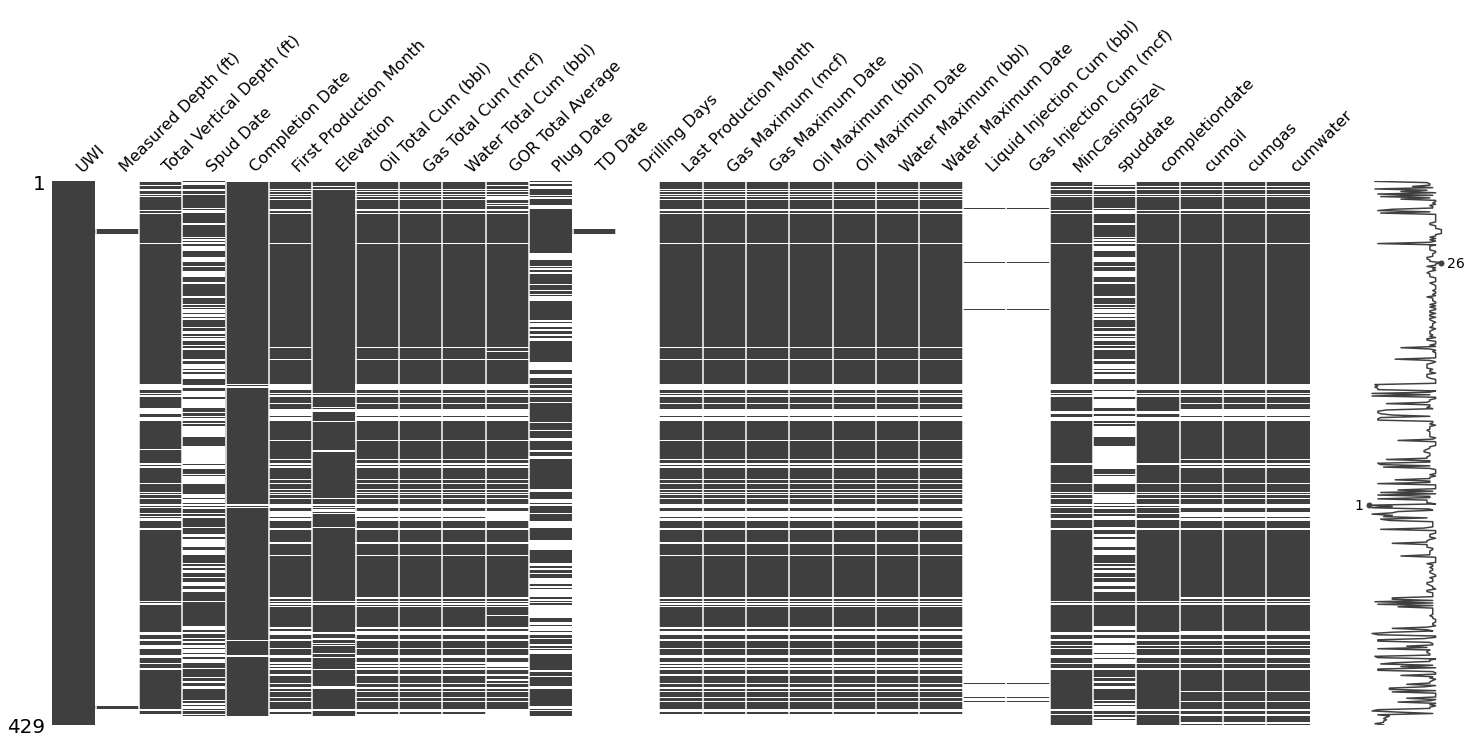

In [35]:
print(production_summary_comb.shape)
msno.matrix(production_summary_comb)

(429, 24)


<AxesSubplot:>

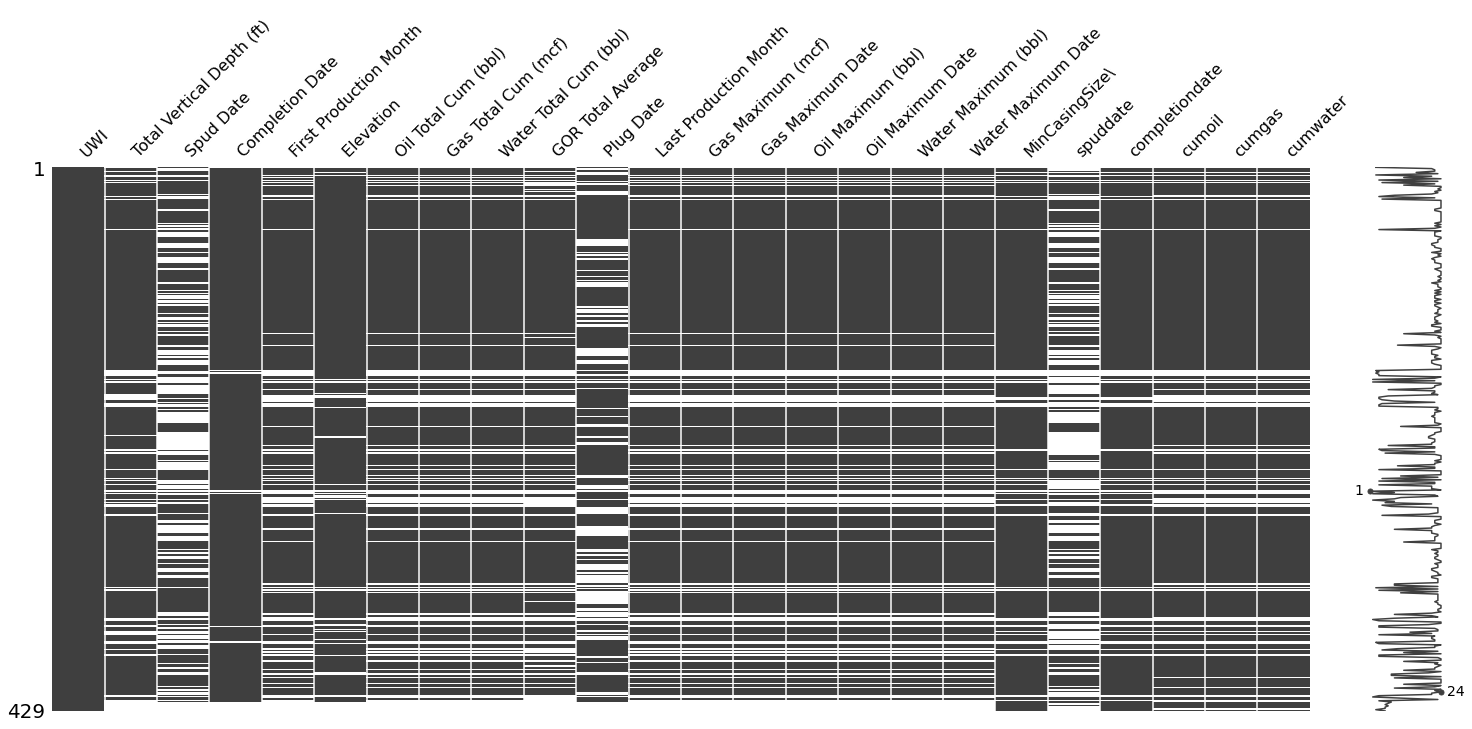

In [36]:
## removing some heavily nan columns
production_summary_comb_1= production_summary_comb.loc[:, production_summary_comb.isnull().mean() < .5]
print(production_summary_comb_1.shape)
msno.matrix(production_summary_comb_1)

In [37]:
production_summary_comb_1.columns

Index(['UWI', 'Total Vertical Depth (ft)   ', 'Spud Date   ',
       'Completion Date   ', 'First Production Month   ', 'Elevation   ',
       'Oil Total Cum (bbl)   ', 'Gas Total Cum (mcf)   ',
       'Water Total Cum (bbl)   ', 'GOR Total Average   ', 'Plug Date   ',
       'Last Production Month   ', 'Gas Maximum (mcf)   ',
       'Gas Maximum Date   ', 'Oil Maximum (bbl)   ', 'Oil Maximum Date   ',
       'Water Maximum (bbl)   ', 'Water Maximum Date   ', 'MinCasingSize\',
       'spuddate', 'completiondate', 'cumoil', 'cumgas', 'cumwater'],
      dtype='object')

C:\Users\ashis\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\series.py:4469: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
C:\Users\ashis\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


<AxesSubplot:>

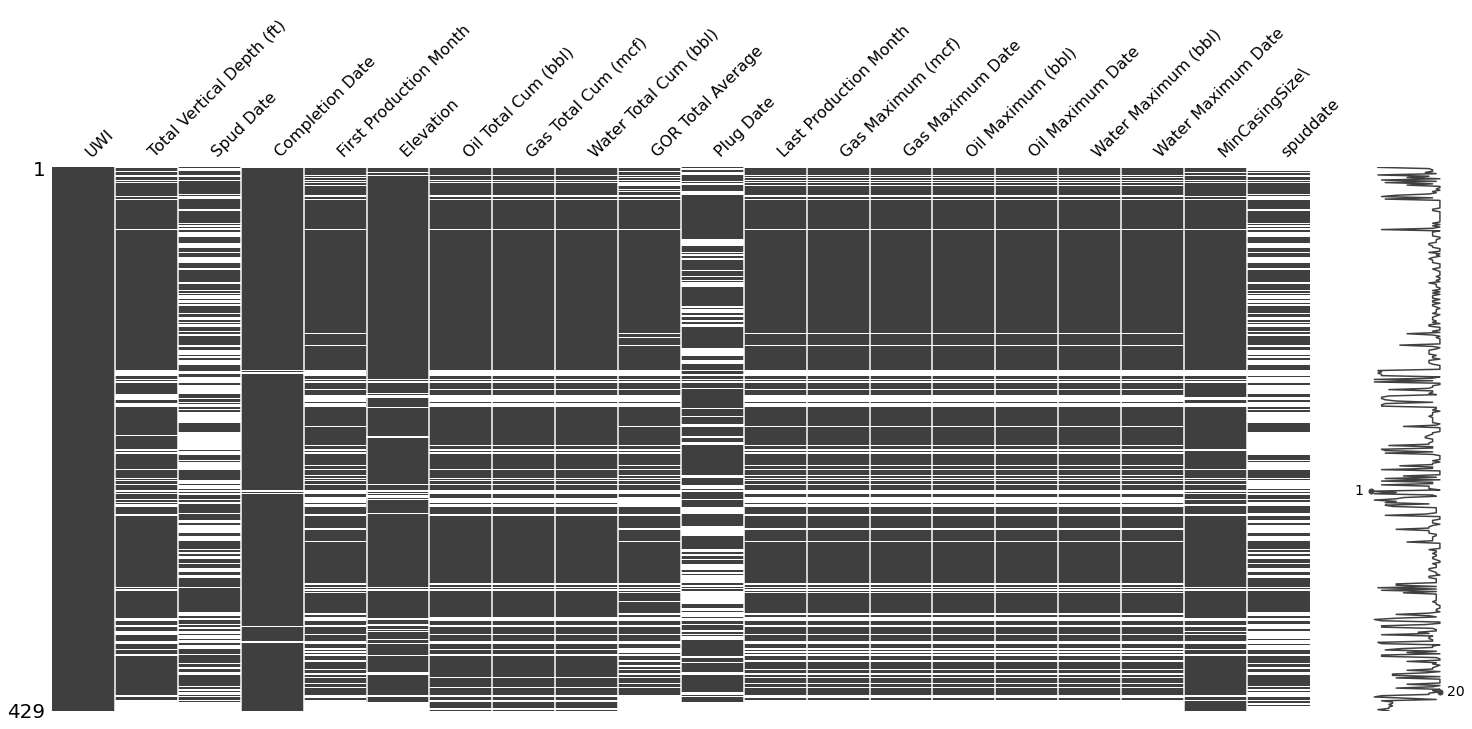

In [38]:
## arranging cum value together and conditional filling of NaN or Empty values
production_summary_comb_1['Completion Date   '].fillna(production_summary_comb_1.completiondate, inplace=True)
production_summary_comb_1['Oil Total Cum (bbl)   '].fillna(production_summary_comb_1.cumoil, inplace=True)
production_summary_comb_1['Gas Total Cum (mcf)   '].fillna(production_summary_comb_1.cumgas, inplace=True)
production_summary_comb_1['Water Total Cum (bbl)   '].fillna(production_summary_comb_1.cumwater, inplace=True)
production_summary_comb_1.drop(['completiondate','cumoil','cumgas','cumwater'],axis=1,inplace=True)
msno.matrix(production_summary_comb_1)

In [39]:
# extracting production time interval
import datetime 
production_summary_comb_1['Production_interval(years)'] = (production_summary_comb_1['Last Production Month   '] -  production_summary_comb_1['First Production Month   ']).dt.days/365

C:\Users\ashis\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [40]:
## dropping date columns
production_summary_comb_1.drop(['Completion Date   ', 'First Production Month   ','Last Production Month   ', 'spuddate','Spud Date   ','Gas Maximum Date   ','Oil Maximum Date   ','Water Maximum Date   ','Plug Date   '],axis=1,inplace=True)

In [41]:
##dropping elevation data as already present in other files
production_summary_comb_1.drop(['Elevation   '],axis=1,inplace=True)

In [42]:
production_summary_comb_1.columns

Index(['UWI', 'Total Vertical Depth (ft)   ', 'Oil Total Cum (bbl)   ',
       'Gas Total Cum (mcf)   ', 'Water Total Cum (bbl)   ',
       'GOR Total Average   ', 'Gas Maximum (mcf)   ', 'Oil Maximum (bbl)   ',
       'Water Maximum (bbl)   ', 'MinCasingSize\',
       'Production_interval(years)'],
      dtype='object')

In [43]:
production_summary_comb_1.head()

,UWI,Total Vertical Depth (ft),Oil Total Cum (bbl),Gas Total Cum (mcf),Water Total Cum (bbl),GOR Total Average,Gas Maximum (mcf),Oil Maximum (bbl),Water Maximum (bbl),MinCasingSize\,Production_interval(years)
0,42013301410000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,42013301930000,10775.0,6140.000,8702967.000,1002330.677,1417421.336,98093.000,271.000,11771.16,5.500,48.452055
2,42013302760000,6168.0,1929.332,7.992,0.000,4.142,0.333,533.333,0.00,4.500,5.594521
3,42013305480000,NaN,0.000,10067.000,0.000,NaN,1464.000,0.000,0.00,2.875,2.495890
4,42013310190000,11000.0,4424.000,6610808.000,47611.388,1494305.606,63674.000,108.000,870.74,NaN,40.109589


In [44]:
# creating dataframes for groupby operations
production_summary_comb_max= production_summary_comb_1[['UWI','Gas Maximum (mcf)   ','Oil Maximum (bbl)   ','Water Maximum (bbl)   ']]
production_summary_comb_cum = production_summary_comb_1[['UWI','Production_interval(years)', 'Oil Total Cum (bbl)   ',
       'Gas Total Cum (mcf)   ', 'Water Total Cum (bbl)   ',
       'GOR Total Average   ']]

In [45]:
## Aggreagting the total production
production_summary_comb_cum_grp = production_summary_comb_cum.groupby('UWI')['Production_interval(years)', 'Oil Total Cum (bbl)   ',
       'Gas Total Cum (mcf)   ', 'Water Total Cum (bbl)   ',
       'GOR Total Average   '].sum()

C:\Users\ashis\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [46]:
### gropuing by for maximum rate by max() getting rid of duplicates. selecting the one with max value
production_summary_comb_max_grp = production_summary_comb_max.groupby('UWI')['Gas Maximum (mcf)   ','Oil Maximum (bbl)   ','Water Maximum (bbl)   '].max()

C:\Users\ashis\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [47]:
### adding static columns
production_summary_comb_static = production_summary_comb_1.iloc[:,[0,1,9]]

In [48]:
## dropping duplicate for Vertical height and casing size as similar for all wells
production_summary_comb_static=production_summary_comb_static.drop_duplicates('UWI',keep='last')

In [49]:
## resetting index 
production_summary_comb_max_grp=production_summary_comb_max_grp.reset_index()
production_summary_comb_cum_grp=production_summary_comb_cum_grp.reset_index()

In [50]:
print(production_summary_comb_cum_grp.shape)
print(production_summary_comb_max_grp.shape)
print(production_summary_comb_static.shape)

(315, 6)
(315, 4)
(315, 3)


In [51]:
print(production_summary_comb_cum_grp['UWI'].isin(production_summary_comb_max_grp['UWI']).value_counts())
print(production_summary_comb_static['UWI'].isin(production_summary_comb_max_grp['UWI']).value_counts())

True    315
Name: UWI, dtype: int64
True    315
Name: UWI, dtype: int64


In [52]:
## merging one by one 
production_summary_comb_final = production_summary_comb_cum_grp.merge(production_summary_comb_max_grp, on='UWI', how='inner')
production_summary_comb_final = production_summary_comb_final.merge(production_summary_comb_static, on='UWI', how='inner')

In [53]:
production_summary_comb_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 315 entries, 0 to 314
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   UWI                           315 non-null    int64  
 1   Production_interval(years)    315 non-null    float64
 2   Oil Total Cum (bbl)           315 non-null    float64
 3   Gas Total Cum (mcf)           315 non-null    float64
 4   Water Total Cum (bbl)         315 non-null    float64
 5   GOR Total Average             315 non-null    float64
 6   Gas Maximum (mcf)             246 non-null    float64
 7   Oil Maximum (bbl)             246 non-null    float64
 8   Water Maximum (bbl)           246 non-null    float64
 9   Total Vertical Depth (ft)     251 non-null    float64
 10  MinCasingSize\                267 non-null    float64
dtypes: float64(10), int64(1)
memory usage: 29.5 KB


## 2.8 Read well header file 

In [54]:
well_header = pd.read_excel('Eaglebine well headers SPE April 21 2021.xlsx')

In [55]:
well_header=well_header.rename(columns={'displayapi': 'UWI'})

<AxesSubplot:>

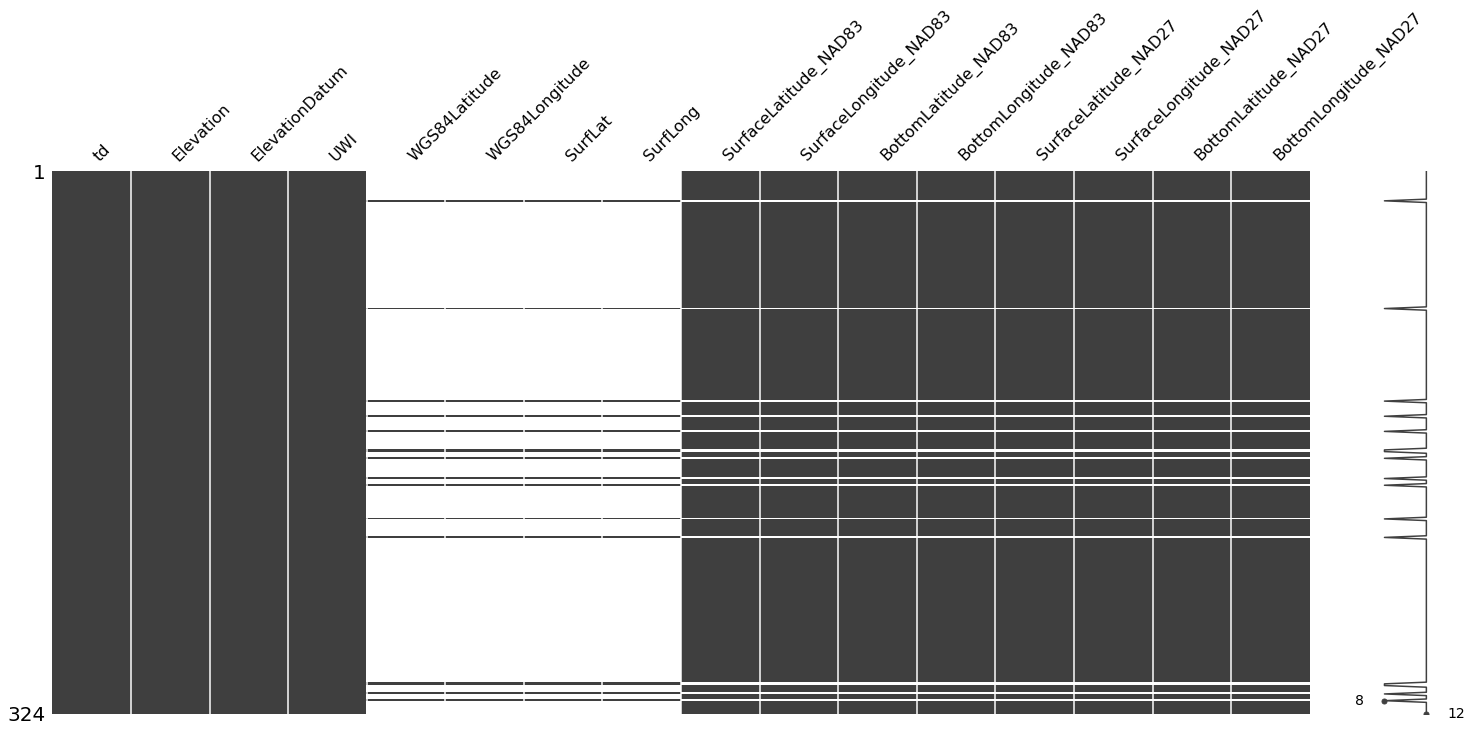

In [56]:
msno.matrix(well_header)

<AxesSubplot:>

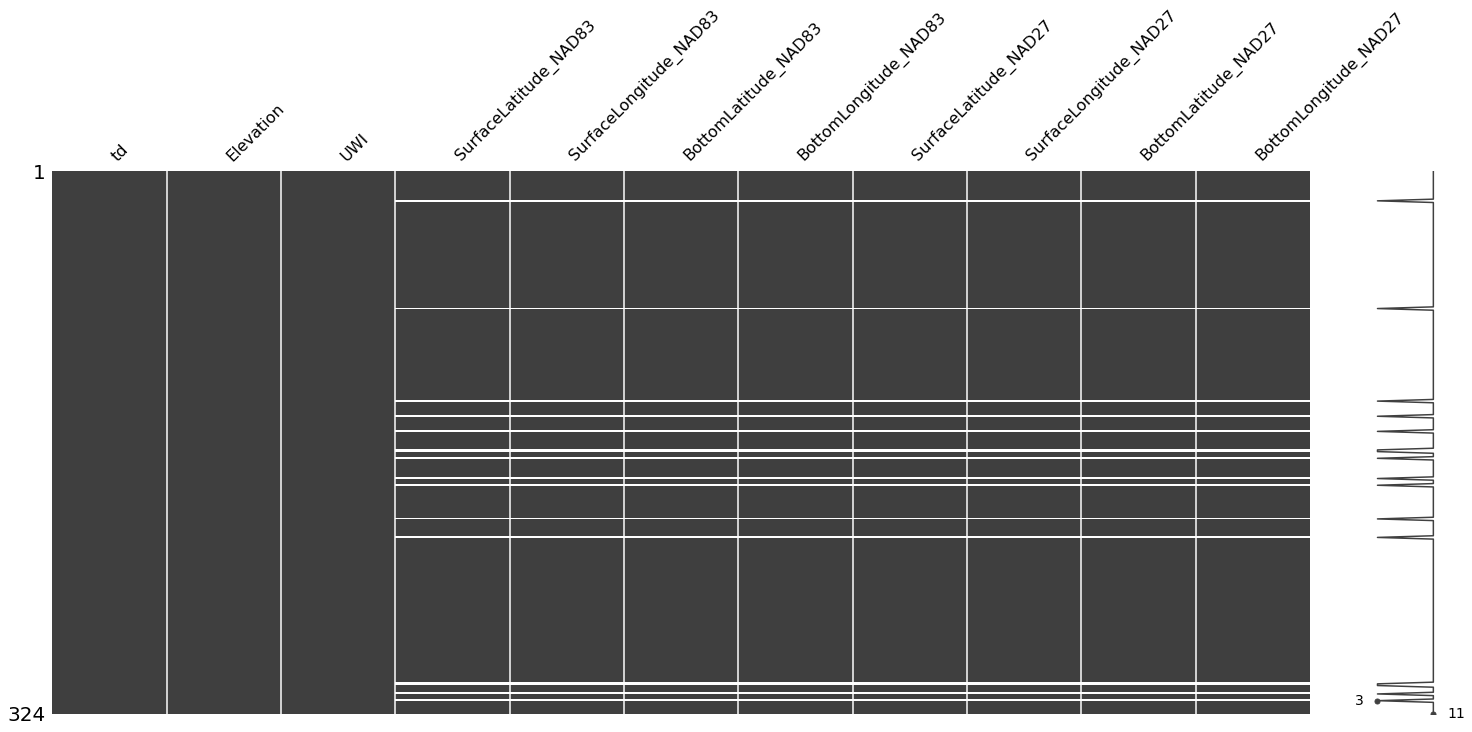

In [57]:
well_header= well_header.loc[:, well_header.isnull().mean() < .5]
well_header.drop('ElevationDatum',inplace=True,axis=1)
msno.matrix(well_header)

In [58]:
well_header.head()

,td,Elevation,UWI,SurfaceLatitude_NAD83,SurfaceLongitude_NAD83,BottomLatitude_NAD83,BottomLongitude_NAD83,SurfaceLatitude_NAD27,SurfaceLongitude_NAD27,BottomLatitude_NAD27,BottomLongitude_NAD27
0,19635,338.68,42013301410000,28.690101,-98.469817,28.690101,-98.469817,28.689839,-98.469523,28.689839,-98.469523
1,10775,384.59,42013301930000,28.780042,-98.208395,28.780042,-98.208396,28.779784,-98.208109,28.779784,-98.208109
2,6175,442.00,42013302760000,28.994810,-98.422767,28.994810,-98.422767,28.994561,-98.422475,28.994561,-98.422475
3,8198,392.00,42013305480000,28.963395,-98.295961,28.963395,-98.295961,28.963144,-98.295673,28.963144,-98.295672
4,11000,493.23,42013310190000,28.817939,-98.155472,28.817939,-98.155472,28.817682,-98.155187,28.817682,-98.155187


In [59]:
well_header.nunique()

td                        305
Elevation                 309
UWI                       324
SurfaceLatitude_NAD83     308
SurfaceLongitude_NAD83    308
BottomLatitude_NAD83      308
BottomLongitude_NAD83     308
SurfaceLatitude_NAD27     308
SurfaceLongitude_NAD27    308
BottomLatitude_NAD27      308
BottomLongitude_NAD27     308
dtype: int64

## 2.9 Read formation tops file

In [60]:
formation_top = pd.read_excel('Eaglebine formation tops SPE April 20 2021.xlsx')

<AxesSubplot:>

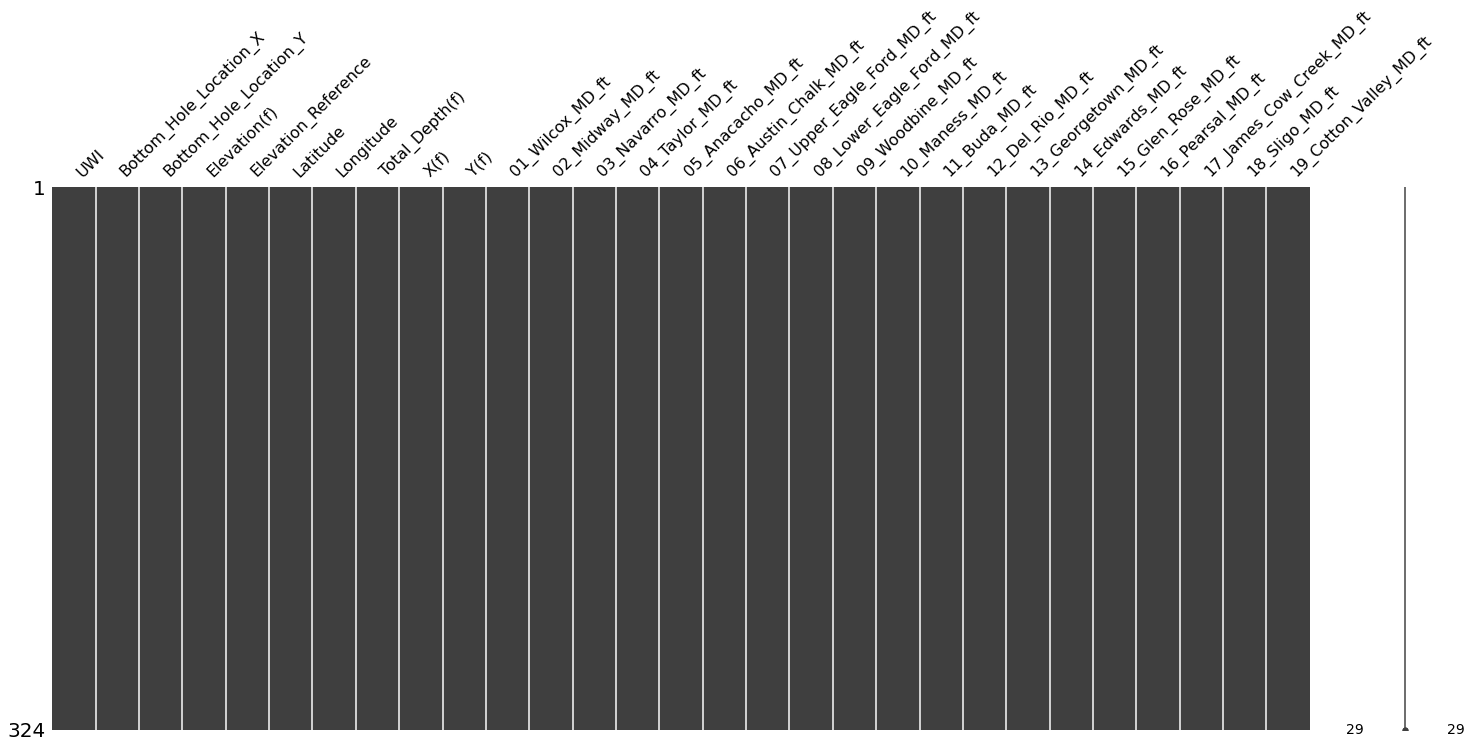

In [61]:
msno.matrix(formation_top)

In [62]:
comb.head()

,UWI,SurfLat,SurfLong,TD (ft),GL(ft),BHT_below sea level (ft),BHT_ subsurface (ft),TSC(hrs),TempC_BHT,diff_depth_abs,True_TempC_Final,TrueTemp_datasource,TD,KB,Mud Wt,MW@Depth(KB),mud depth,mud_diff_depth,mud_diff_depth_abs
522,42507326870000,29.001905,-99.586898,4016.0,787.90,3246.50,4034.4,4.0,50.000000,3.50,78.888889,static_temp_logs,4016.0,769.50,10.30,4016.0,3246.50,0.0,0.0
521,42507312960000,29.075911,-100.006371,7191.0,839.85,6329.55,7169.4,9.0,67.222222,20.45,94.794444,synthetic,7191.0,821.45,9.30,7151.0,6329.55,0.0,0.0
518,42507312420000,28.742901,-100.077454,10120.0,660.70,3257.70,3918.4,3.0,54.444444,NaN,NaN,NaN,10120.0,642.30,9.70,3900.0,3257.70,0.0,0.0
512,42507007550000,28.775181,-99.562393,16152.0,766.40,4254.00,5020.4,4.0,65.555556,4.00,78.161111,synthetic,16152.0,748.00,9.70,5002.0,4254.00,0.0,0.0
511,42493322270000,29.059620,-98.210121,6390.0,487.40,5921.00,6408.4,6.0,73.333333,NaN,NaN,NaN,6390.0,469.00,9.85,6390.0,5921.00,0.0,0.0


In [63]:
formation_top.head()

,UWI,Bottom_Hole_Location_X,Bottom_Hole_Location_Y,Elevation(f),Elevation_Reference,Latitude,Longitude,Total_Depth(f),X(f),Y(f),01_Wilcox_MD_ft,02_Midway_MD_ft,03_Navarro_MD_ft,04_Taylor_MD_ft,05_Anacacho_MD_ft,06_Austin_Chalk_MD_ft,07_Upper_Eagle_Ford_MD_ft,08_Lower_Eagle_Ford_MD_ft,09_Woodbine_MD_ft,10_Maness_MD_ft,11_Buda_MD_ft,12_Del_Rio_MD_ft,13_Georgetown_MD_ft,14_Edwards_MD_ft,15_Glen_Rose_MD_ft,16_Pearsal_MD_ft,17_James_Cow_Creek_MD_ft,18_Sligo_MD_ft,19_Cotton_Valley_MD_ft
0,42013301410000,2170169.05,311696.26,328.0,KB,28.689529,-98.469238,0,2170169.05,311696.26,1464.64,4455.92,4927.92,7608.13,9164.50,9457.17,9558.71,9609.42,0.0,0.0,9712.58,9809.80,9862.60,9942.73,10796.27,12251.06,12534.95,12718.48,0.0
1,42013301930000,2253601.52,345032.51,379.0,KB,28.779921,-98.208313,0,2253601.52,345032.51,0.00,0.00,0.00,0.00,9933.17,10039.33,10127.58,10175.75,0.0,0.0,10280.42,10366.00,10405.21,0.00,0.00,0.00,0.00,0.00,0.0
2,42013302760000,2184830.73,422595.91,442.0,KB,28.994360,-98.421799,6168,2184830.73,422595.91,0.00,3553.31,4004.63,0.00,5521.92,5758.25,6024.93,6047.04,0.0,0.0,6100.62,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
3,42013305480000,2225271.51,411448.83,392.0,KB,28.963091,-98.295502,0,2225271.51,411448.83,0.00,0.00,0.00,0.00,7336.83,7530.67,7676.58,7735.83,0.0,0.0,7807.00,7908.82,7964.25,0.00,0.00,0.00,0.00,0.00,0.0
4,42013310190000,2270478.34,358777.49,491.0,KB,28.817400,-98.155319,0,2270478.34,358777.49,0.00,0.00,0.00,0.00,10062.17,10164.00,10254.50,10304.83,0.0,0.0,10393.50,10469.50,10503.75,10566.88,0.00,0.00,0.00,0.00,0.0


# 3. Merging well_header,mud_weight, formation_tops files to dataset

In [64]:
comb['UWI'] = comb['UWI'].astype('int64')

In [65]:
comb_file_1= comb.merge(production_summary_comb_final,on='UWI', how='left')
comb_file_1.head()

,UWI,SurfLat,SurfLong,TD (ft),GL(ft),BHT_below sea level (ft),BHT_ subsurface (ft),TSC(hrs),TempC_BHT,diff_depth_abs,True_TempC_Final,TrueTemp_datasource,TD,KB,Mud Wt,MW@Depth(KB),mud depth,mud_diff_depth,mud_diff_depth_abs,Production_interval(years),Oil Total Cum (bbl),Gas Total Cum (mcf),Water Total Cum (bbl),GOR Total Average,Gas Maximum (mcf),Oil Maximum (bbl),Water Maximum (bbl),Total Vertical Depth (ft),MinCasingSize\
0,42507326870000,29.001905,-99.586898,4016.0,787.90,3246.50,4034.4,4.0,50.000000,3.50,78.888889,static_temp_logs,4016.0,769.50,10.30,4016.0,3246.50,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,4.500
1,42507312960000,29.075911,-100.006371,7191.0,839.85,6329.55,7169.4,9.0,67.222222,20.45,94.794444,synthetic,7191.0,821.45,9.30,7151.0,6329.55,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2,42507312420000,28.742901,-100.077454,10120.0,660.70,3257.70,3918.4,3.0,54.444444,NaN,NaN,NaN,10120.0,642.30,9.70,3900.0,3257.70,0.0,0.0,0.915068,0.0,6074.0,0.0,0.0,2000.0,0.0,0.0,10070.0,2.375
3,42507007550000,28.775181,-99.562393,16152.0,766.40,4254.00,5020.4,4.0,65.555556,4.00,78.161111,synthetic,16152.0,748.00,9.70,5002.0,4254.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
4,42493322270000,29.059620,-98.210121,6390.0,487.40,5921.00,6408.4,6.0,73.333333,NaN,NaN,NaN,6390.0,469.00,9.85,6390.0,5921.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN


In [66]:
comb_file_2 = comb_file_1.merge(well_header,on='UWI', how='left')
comb_file_2.head()

,UWI,SurfLat,SurfLong,TD (ft),GL(ft),BHT_below sea level (ft),BHT_ subsurface (ft),TSC(hrs),TempC_BHT,diff_depth_abs,True_TempC_Final,TrueTemp_datasource,TD,KB,Mud Wt,MW@Depth(KB),mud depth,mud_diff_depth,mud_diff_depth_abs,Production_interval(years),Oil Total Cum (bbl),Gas Total Cum (mcf),Water Total Cum (bbl),GOR Total Average,Gas Maximum (mcf),Oil Maximum (bbl),Water Maximum (bbl),Total Vertical Depth (ft),MinCasingSize\,td,Elevation,SurfaceLatitude_NAD83,SurfaceLongitude_NAD83,BottomLatitude_NAD83,BottomLongitude_NAD83,SurfaceLatitude_NAD27,SurfaceLongitude_NAD27,BottomLatitude_NAD27,BottomLongitude_NAD27
0,42507326870000,29.001905,-99.586898,4016.0,787.90,3246.50,4034.4,4.0,50.000000,3.50,78.888889,static_temp_logs,4016.0,769.50,10.30,4016.0,3246.50,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,4.500,4016,766.44,29.001905,-99.586898,29.001905,-99.586898,29.001658,-99.586569,29.001658,-99.586569
1,42507312960000,29.075911,-100.006371,7191.0,839.85,6329.55,7169.4,9.0,67.222222,20.45,94.794444,synthetic,7191.0,821.45,9.30,7151.0,6329.55,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,7191,821.45,29.077015,-100.006558,29.077015,-100.006558,29.076772,-100.006217,29.076772,-100.006217
2,42507312420000,28.742901,-100.077454,10120.0,660.70,3257.70,3918.4,3.0,54.444444,NaN,NaN,NaN,10120.0,642.30,9.70,3900.0,3257.70,0.0,0.0,0.915068,0.0,6074.0,0.0,0.0,2000.0,0.0,0.0,10070.0,2.375,10120,662.62,28.743033,-100.077765,28.743033,-100.077766,28.742779,-100.077425,28.742779,-100.077425
3,42507007550000,28.775181,-99.562393,16152.0,766.40,4254.00,5020.4,4.0,65.555556,4.00,78.161111,synthetic,16152.0,748.00,9.70,5002.0,4254.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,16156,748.00,28.774927,-99.562068,28.774926,-99.562065,28.774672,-99.561743,28.774671,-99.561740
4,42493322270000,29.059620,-98.210121,6390.0,487.40,5921.00,6408.4,6.0,73.333333,NaN,NaN,NaN,6390.0,469.00,9.85,6390.0,5921.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,6390,466.76,29.059883,-98.210294,29.059883,-98.210294,29.059636,-98.210007,29.059636,-98.210007


In [67]:
comb_file_final = comb_file_2.merge(formation_top,on='UWI', how='left')

In [68]:
comb_file_final.head()

,UWI,SurfLat,SurfLong,TD (ft),GL(ft),BHT_below sea level (ft),BHT_ subsurface (ft),TSC(hrs),TempC_BHT,diff_depth_abs,True_TempC_Final,TrueTemp_datasource,TD,KB,Mud Wt,MW@Depth(KB),mud depth,mud_diff_depth,mud_diff_depth_abs,Production_interval(years),Oil Total Cum (bbl),Gas Total Cum (mcf),Water Total Cum (bbl),GOR Total Average,Gas Maximum (mcf),Oil Maximum (bbl),Water Maximum (bbl),Total Vertical Depth (ft),MinCasingSize\,td,Elevation,SurfaceLatitude_NAD83,SurfaceLongitude_NAD83,BottomLatitude_NAD83,BottomLongitude_NAD83,SurfaceLatitude_NAD27,SurfaceLongitude_NAD27,BottomLatitude_NAD27,BottomLongitude_NAD27,Bottom_Hole_Location_X,Bottom_Hole_Location_Y,Elevation(f),Elevation_Reference,Latitude,Longitude,Total_Depth(f),X(f),Y(f),01_Wilcox_MD_ft,02_Midway_MD_ft,03_Navarro_MD_ft,04_Taylor_MD_ft,05_Anacacho_MD_ft,06_Austin_Chalk_MD_ft,07_Upper_Eagle_Ford_MD_ft,08_Lower_Eagle_Ford_MD_ft,09_Woodbine_MD_ft,10_Maness_MD_ft,11_Buda_MD_ft,12_Del_Rio_MD_ft,13_Georgetown_MD_ft,14_Edwards_MD_ft,15_Glen_Rose_MD_ft,16_Pearsal_MD_ft,17_James_Cow_Creek_MD_ft,18_Sligo_MD_ft,19_Cotton_Valley_MD_ft
0,42507326870000,29.001905,-99.586898,4016.0,787.90,3246.50,4034.4,4.0,50.000000,3.50,78.888889,static_temp_logs,4016.0,769.50,10.30,4016.0,3246.50,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,4.500,4016,766.44,29.001905,-99.586898,29.001905,-99.586898,29.001658,-99.586569,29.001658,-99.586569,1812507.42,425263.32,769.0,KB,29.001660,-99.586570,0,1812507.42,425263.32,0.0,0.0,1400.0,2280.00,2565.33,2787.50,3308.09,3406.21,0.0,0.0,3492.50,3584.00,3691.00,3780.33,0.00,0.00,0.0,0.00,0.0
1,42507312960000,29.075911,-100.006371,7191.0,839.85,6329.55,7169.4,9.0,67.222222,20.45,94.794444,synthetic,7191.0,821.45,9.30,7151.0,6329.55,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,7191,821.45,29.077015,-100.006558,29.077015,-100.006558,29.076772,-100.006217,29.076772,-100.006217,1678556.34,453171.98,741.0,KB,29.075911,-100.006371,0,1678556.34,453171.98,0.0,0.0,0.0,0.00,1365.00,1649.50,2721.59,2768.88,0.0,0.0,2865.07,2949.23,3038.83,0.00,0.00,0.00,0.0,0.00,0.0
2,42507312420000,28.742901,-100.077454,10120.0,660.70,3257.70,3918.4,3.0,54.444444,NaN,NaN,NaN,10120.0,642.30,9.70,3900.0,3257.70,0.0,0.0,0.915068,0.0,6074.0,0.0,0.0,2000.0,0.0,0.0,10070.0,2.375,10120,662.62,28.743033,-100.077765,28.743033,-100.077766,28.742779,-100.077425,28.742779,-100.077425,1654736.96,332305.13,642.0,KB,28.742901,-100.077454,0,1654736.96,332305.13,0.0,0.0,0.0,0.00,0.00,3750.80,4627.79,4911.60,0.0,0.0,5119.83,5282.50,5552.70,5591.57,0.00,0.00,0.0,0.00,0.0
3,42507007550000,28.775181,-99.562393,16152.0,766.40,4254.00,5020.4,4.0,65.555556,4.00,78.161111,synthetic,16152.0,748.00,9.70,5002.0,4254.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,16156,748.00,28.774927,-99.562068,28.774926,-99.562065,28.774672,-99.561743,28.774671,-99.561740,1819839.32,342884.06,748.0,KB,28.775181,-99.562393,0,1819839.32,342884.06,0.0,0.0,0.0,4129.54,5294.67,5617.83,6184.30,6369.32,0.0,0.0,6495.47,6623.00,6762.00,6824.22,7681.61,9832.88,0.0,10457.63,0.0
4,42493322270000,29.059620,-98.210121,6390.0,487.40,5921.00,6408.4,6.0,73.333333,NaN,NaN,NaN,6390.0,469.00,9.85,6390.0,5921.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,6390,466.76,29.059883,-98.210294,29.059883,-98.210294,29.059636,-98.210007,29.059636,-98.210007,2252335.51,446718.15,489.0,KB,29.059620,-98.210121,0,2252335.51,446718.15,0.0,0.0,0.0,0.00,5878.00,5996.00,6184.42,6194.08,0.0,0.0,6245.50,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0


In [69]:
comb_file_final.columns

Index(['UWI', 'SurfLat', 'SurfLong', 'TD (ft)', 'GL(ft)',
       'BHT_below sea level (ft)', 'BHT_ subsurface (ft)', 'TSC(hrs)',
       'TempC_BHT', 'diff_depth_abs', 'True_TempC_Final',
       'TrueTemp_datasource', 'TD', 'KB', 'Mud Wt', 'MW@Depth(KB)',
       'mud depth', 'mud_diff_depth', 'mud_diff_depth_abs',
       'Production_interval(years)', 'Oil Total Cum (bbl)   ',
       'Gas Total Cum (mcf)   ', 'Water Total Cum (bbl)   ',
       'GOR Total Average   ', 'Gas Maximum (mcf)   ', 'Oil Maximum (bbl)   ',
       'Water Maximum (bbl)   ', 'Total Vertical Depth (ft)   ',
       'MinCasingSize\', 'td', 'Elevation', 'SurfaceLatitude_NAD83',
       'SurfaceLongitude_NAD83', 'BottomLatitude_NAD83',
       'BottomLongitude_NAD83', 'SurfaceLatitude_NAD27',
       'SurfaceLongitude_NAD27', 'BottomLatitude_NAD27',
       'BottomLongitude_NAD27', 'Bottom_Hole_Location_X',
       'Bottom_Hole_Location_Y', 'Elevation(f)', 'Elevation_Reference',
       'Latitude', 'Longitude', 'Total_Depth(f)

## 3.1 Description of  the final file

In [70]:
comb_file_final.shape

(324, 67)

<AxesSubplot:>

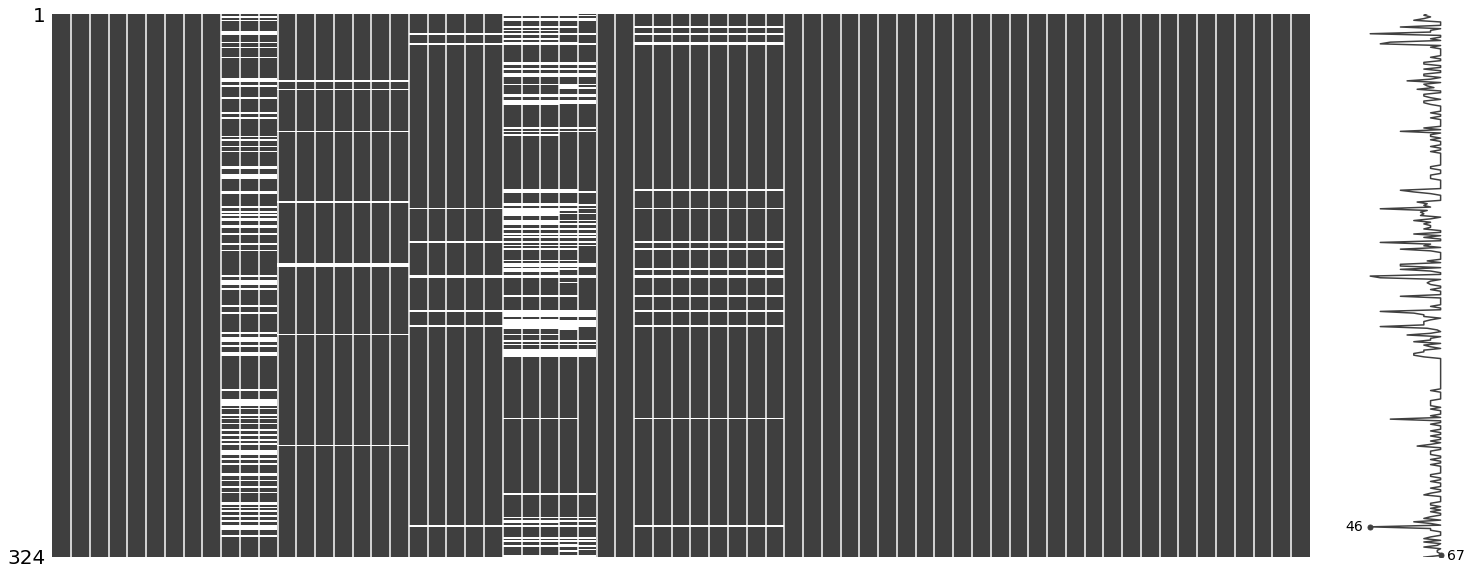

In [71]:
msno.matrix(comb_file_final)

In [72]:
comb_file_final.describe()

,UWI,SurfLat,SurfLong,TD (ft),GL(ft),BHT_below sea level (ft),BHT_ subsurface (ft),TSC(hrs),TempC_BHT,diff_depth_abs,True_TempC_Final,TD,KB,Mud Wt,MW@Depth(KB),mud depth,mud_diff_depth,mud_diff_depth_abs,Production_interval(years),Oil Total Cum (bbl),Gas Total Cum (mcf),Water Total Cum (bbl),GOR Total Average,Gas Maximum (mcf),Oil Maximum (bbl),Water Maximum (bbl),Total Vertical Depth (ft),MinCasingSize\,td,Elevation,SurfaceLatitude_NAD83,SurfaceLongitude_NAD83,BottomLatitude_NAD83,BottomLongitude_NAD83,SurfaceLatitude_NAD27,SurfaceLongitude_NAD27,BottomLatitude_NAD27,BottomLongitude_NAD27,Bottom_Hole_Location_X,Bottom_Hole_Location_Y,Elevation(f),Latitude,Longitude,Total_Depth(f),X(f),Y(f),01_Wilcox_MD_ft,02_Midway_MD_ft,03_Navarro_MD_ft,04_Taylor_MD_ft,05_Anacacho_MD_ft,06_Austin_Chalk_MD_ft,07_Upper_Eagle_Ford_MD_ft,08_Lower_Eagle_Ford_MD_ft,09_Woodbine_MD_ft,10_Maness_MD_ft,11_Buda_MD_ft,12_Del_Rio_MD_ft,13_Georgetown_MD_ft,14_Edwards_MD_ft,15_Glen_Rose_MD_ft,16_Pearsal_MD_ft,17_James_Cow_Creek_MD_ft,18_Sligo_MD_ft,19_Cotton_Valley_MD_ft
count,3.240000e+02,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.00000,324.000000,243.000000,243.000000,316.000000,316.000000,316.000000,316.000000,316.000000,316.000000,316.000000,315.000000,315.000000,3.150000e+02,3.150000e+02,3.150000e+02,246.000000,246.000000,246.000000,251.000000,267.000000,324.000000,324.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,3.240000e+02,3.240000e+02,324.000000,324.000000,324.000000,324.000000,3.240000e+02,3.240000e+02,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000
mean,4.218632e+13,29.797972,-97.122295,9744.379630,440.697654,8524.312222,8965.009877,6.76929,94.928669,89.028642,114.340356,9764.060127,422.406203,10.007120,9010.642405,8588.236203,42.852215,43.010443,12.213151,34926.888263,6.323745e+05,3.924744e+04,2.460939e+07,24276.021699,2450.208846,1759.535610,9561.601594,3.906835,9730.743827,422.411111,29.926328,-97.389442,29.926151,-97.389253,29.926106,-97.389172,29.925929,-97.388984,2.497728e+06,7.548998e+05,421.818519,29.894213,-97.417996,1554.052469,2.497728e+06,7.548993e+05,298.578642,1332.083086,1475.065617,1346.087809,6159.495247,7135.460772,1857.241111,7314.195000,2419.842716,2601.918519,7983.099630,7228.466204,6481.140864,4493.811296,1895.453426,1538.037346,1391.030648,1607.048333,659.433117
std,1.407381e+11,1.929210,5.557704,2992.341139,131.695386,2730.324947,2693.450734,8.36953,26.331159,514.462798,24.034569,3000.348456,131.691555,1.388692,2685.163512,2723.234804,525.552462,525.539495,13.237170,62369.494387,1.970528e+06,2.117705e+05,3.105509e+08,71593.287741,3362.905412,7227.600775,2542.486336,1.803438,2980.194117,133.500243,0.990394,1.275258,0.990352,1.275062,0.990424,1.275226,0.990382,1.275030,3.990181e+05,3.613672e+05,131.671042,0.983438,1.266612,3659.705263,3.990181e+05,3.613669e+05,1118.549794,2382.302987,2516.018471,2726.490910,3017.696853,2557.303608,3289.185310,2804.673862,3510.569985,3722.316034,2243.277249,3304.776259,3818.444843,4427.609867,3552.423569,3498.007940,3374.479801,3645.801979,2655.887735
min,4.201330e+13,0.000000,-100.506157,4016.000000,195.150000,1843.000000,2221.400000,0.00000,37.777778,0.900000,45.838889,4016.000000,176.750000,8.300000,2203.000000,1843.000000,-25.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,4994.000000,2.000000,4016.000000,21.650000,27.975343,-100.506986,27.975343,-100.506986,27.975060,-100.506631,27.975060,-100.506631,1.517722e+06,5.213792e+04,154.000000,27.975010,-100.506157,0.000000,1.517722e+06,5.213792e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2729.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.205131e+13,28.920858,-98.156673,7

In [73]:
comb_file_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 324 entries, 0 to 323
Data columns (total 67 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   UWI                           324 non-null    int64  
 1   SurfLat                       324 non-null    float64
 2   SurfLong                      324 non-null    float64
 3   TD (ft)                       324 non-null    float64
 4   GL(ft)                        324 non-null    float64
 5   BHT_below sea level (ft)      324 non-null    float64
 6   BHT_ subsurface (ft)          324 non-null    float64
 7   TSC(hrs)                      324 non-null    float64
 8   TempC_BHT                     324 non-null    float64
 9   diff_depth_abs                243 non-null    float64
 10  True_TempC_Final              243 non-null    float64
 11  TrueTemp_datasource           243 non-null    object 
 12  TD                            316 non-null    float64
 13  KB   